## Patrick Peng
## 570 Hw2

In [276]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from pandas import DataFrame as daf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
random.seed(10)

In [277]:
#Variance
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [278]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))

    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [279]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1


    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates

    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])

    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]

        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]

    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

# Q1 Covariates

#

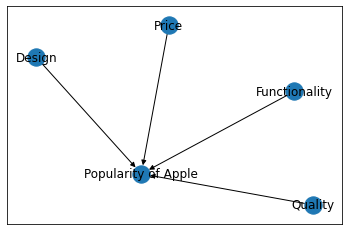

In [280]:
#DAG
graph = nx.DiGraph()
graph.add_edges_from([("Price", "Popularity of Apple"), ("Design", "Popularity of Apple"),("Quality", "Popularity of Apple"),("Functionality", "Popularity of Apple")])
k = plt.tight_layout()

nx.draw_networkx(graph, arrows=True)


# Example:
# the Popularity of Apple is not only affected by its Price, but also affected by its Design, Quality, Functionality

##  Q1) No covariates in the DGP
$y_i = \tau*T_i+e_i$

In [281]:
tau = 8
corr = .6
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:02<00:00, 181.22it/s]


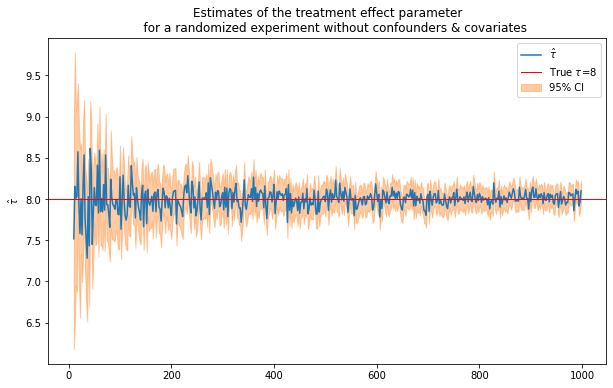

In [282]:
caption = """Estimates of the treatment effect parameter
    for a randomized experiment without confounders & covariates"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

In [283]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [284]:
# Tau hat & S.d Tauhat

In [285]:
tauhat,se_tauhat

(8.204892253852599, 0.19925961235881925)

In [286]:
# check the amount with OLS

In [287]:

const = np.ones([N,1])

In [288]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()

res.params[0], res.HC1_se[0]

(8.204892253852602, 0.19925961235881928)

In [289]:
#R Monte Carlo & bias,RMSE and size

In [290]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:07<00:00, 252.31it/s]


In [291]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')


N=100: bias=0.0019331566254980408, RMSE=0.20254482885917535, size=0.0555
N=1000: bias=-0.0017099158357443702, RMSE=0.06365868094836438, size=0.056


# Q1) Covariates in the DGP
$y_i = \tau*T_i+\beta*X_i+e_i$


In [292]:
tau = 8
corr = .6
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████| 450/450 [00:14<00:00, 30.78it/s]


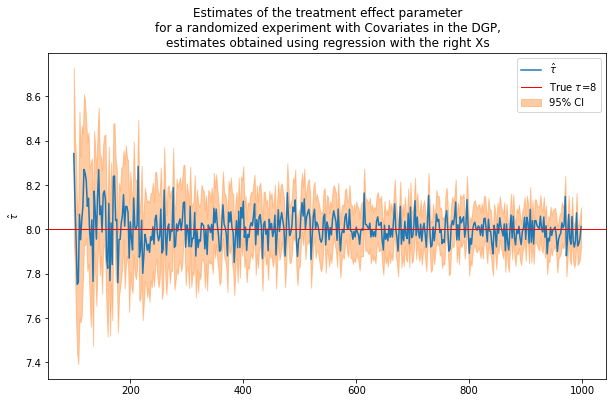

In [293]:
caption = """Estimates of the treatment effect parameter
for a randomized experiment with Covariates in the DGP,
estimates obtained using regression with the right Xs"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

In [294]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]


In [295]:
tauhat,se_tauhat


(8.009722108579718, 0.19615101322696993)

In [296]:
# check the amount with OLS

In [297]:

const = np.ones([N,1])


In [298]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.params[0], res.HC1_se[0]


(8.009722108579718, 0.19615101322696996)

In [299]:
#R Monte Carlo & bias,RMSE and size

In [300]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:08<00:00, 247.68it/s]


In [301]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print (f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.00876364533775727, RMSE=0.20048207845161164, size=0.0545
N=1000: bias=0.0008123238005449518, RMSE=0.06190327841246337, size=0.0445


# Q2 Confounder


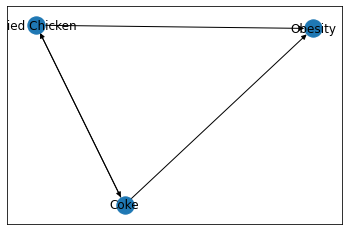

In [302]:
#DAG
graph = nx.DiGraph()
graph.add_edges_from([("Coke", "Obesity"),("Fried Chicken","Obesity"),("Coke","Fried Chicken"),("Fried Chicken","Coke")])
k = plt.tight_layout()

nx.draw_networkx(graph, arrows=True)

# Example:
# Fried Chicken is a example of Confounder
# Coke and Fried chicken will affect each other's consumption and both of them will cause Obesity

## Q2) No Confounder


In [303]:
tau = 8
corr = .6
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)


100%|██████████| 495/495 [00:02<00:00, 176.11it/s]


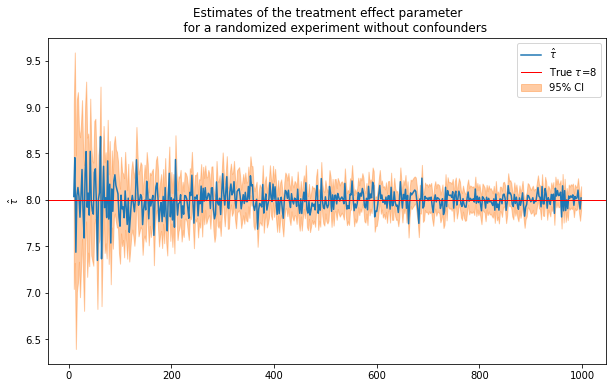

In [304]:
caption = """Estimates of the treatment effect parameter
    for a randomized experiment without confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)


In [305]:
N = 100
Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf=False)
Yt = Yexp[np.where(T == 1)[0], :]
Yc = Yexp[np.where(T == 0)[0], :]
tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
lb = lb + [tauhat - 1.96 * se_tauhat]
ub = ub + [tauhat + 1.96 * se_tauhat]
# Tau hat & S.d Tauhat
tauhat, se_tauhat


(7.897479757920165, 0.22257844061922039)

In [306]:
# check the amount with OLS
const = np.ones([N, 1])
model = sm.OLS(Yexp, np.concatenate([T, const], axis=1))
res = model.fit()
res.params[0], res.HC1_se[0]


(7.897479757920163, 0.22257844061922036)

In [307]:
#R Monte Carlo & bias,RMSE and size

In [308]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

100%|██████████| 2000/2000 [00:08<00:00, 245.95it/s]

N=100: bias=0.0036531309912944, RMSE=0.19961991428891943, size=0.0515
N=1000: bias=0.0004949894687478178, RMSE=0.06217378426767596, size=0.0455


## Q2) With Confounder


100%|██████████| 495/495 [00:02<00:00, 182.07it/s]


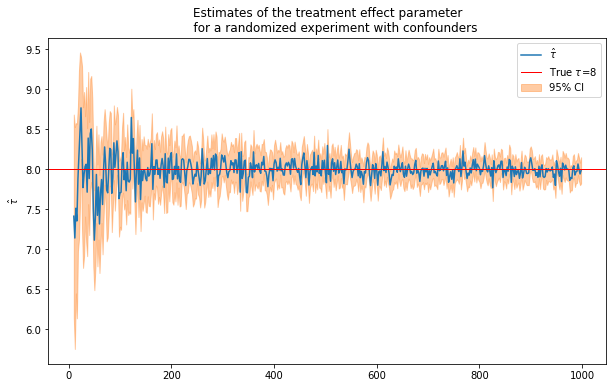

In [309]:
tau = 8
corr = .6
conf = True
p = 100
p0 = 0  # number of covariates used in the DGP
Nrange = range(10, 1000, 2)  # loop over N values
(nvalues3, tauhats3, sehats3, lb3, ub3) = fn_run_experiments(tau, Nrange, p, p0, corr, conf)

caption = """Estimates of the treatment effect parameter
    for a randomized experiment with confounders"""
fn_plot_with_ci(nvalues3, tauhats3, tau, lb3, ub3, caption)

In [310]:
N = 100
Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf= True)
Yt = Yexp[np.where(T == 1)[0], :]
Yc = Yexp[np.where(T == 0)[0], :]
tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
lb = lb + [tauhat - 1.96 * se_tauhat]
ub = ub + [tauhat + 1.96 * se_tauhat]
# Tau hat & S.d Tauhat
tauhat, se_tauhat

(8.343636095584126, 0.25757601917069706)

In [311]:
# check the amount with OLS
const = np.ones([N, 1])
model = sm.OLS(Yexp, np.concatenate([T, const], axis=1))
res = model.fit()
res.params[0], res.HC1_se[0]

(8.343636095584126, 0.257576019170697)

In [312]:
#R Monte Carlo & bias,RMSE and size
estDict = {}
R = 2000
for N in [100, 1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf)
        Yt = Yexp[np.where(T == 1)[0], :]
        Yc = Yexp[np.where(T == 0)[0], :]
        tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat': np.array(tauhats).reshape([len(tauhats), 1]),
        'sehat': np.array(sehats).reshape([len(sehats), 1])
    }
tau0 = tau * np.ones([R, 1])
for N, results in estDict.items():
    (bias, rmse, size) = fn_bias_rmse_size(tau0, results['tauhat'],
                                           results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')


100%|██████████| 2000/2000 [00:07<00:00, 251.72it/s]

N=100: bias=0.0002560359940100851, RMSE=0.22746247195634048, size=0.053
N=1000: bias=0.001559511694651349, RMSE=0.07332942502415163, size=0.0535


# Q3 Selection Bias


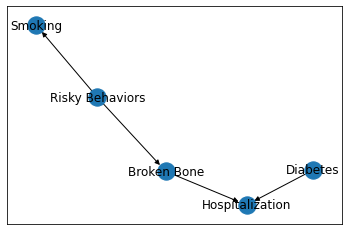

In [313]:
#DAG
graph = nx.DiGraph()
graph.add_edges_from([("Risky Behaviors", "Smoking"),("Risky Behaviors","Broken Bone"),("Broken Bone","Hospitalization"),("Diabetes","Hospitalization")])
k = plt.tight_layout()

nx.draw_networkx(graph, arrows=True)

## In reality Smoking does not have causal effect on Diabetes. But in this example, as sample all selected from hospital, smoking was wrongly linked with Diabetes.

## Q3) NO Selection Bias

In [314]:
tau = 8
corr = .6
conf= True
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████| 450/450 [00:15<00:00, 29.89it/s]


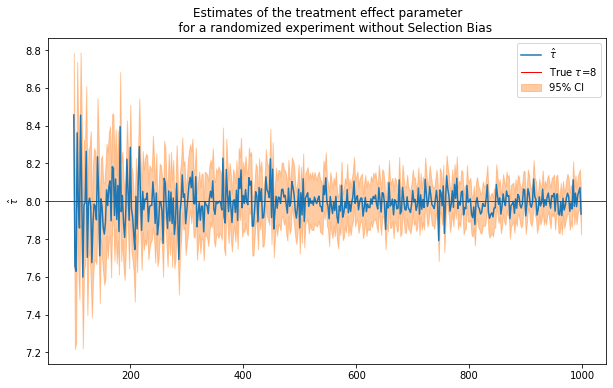

In [315]:
caption = """Estimates of the treatment effect parameter
    for a randomized experiment without Selection Bias"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)


In [316]:
N = 100
Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf=True)
Yt = Yexp[np.where(T == 1)[0], :]
Yc = Yexp[np.where(T == 0)[0], :]
tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
lb = lb + [tauhat - 1.96 * se_tauhat]
ub = ub + [tauhat + 1.96 * se_tauhat]

tauhat, se_tauhat


(8.328052436749813, 0.23109108574361475)

In [317]:
# check the amount with OLS
const = np.ones([N, 1])

model = sm.OLS(Yexp, np.concatenate([T, const], axis=1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(8.328052436749813, 0.23109108574361473)

In [318]:
#R Monte Carlo & bias,RMSE and size
estDict = {}
R = 2000
for N in [100, 1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf)
        Yt = Yexp[np.where(T == 1)[0], :]
        Yc = Yexp[np.where(T == 0)[0], :]
        tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat': np.array(tauhats).reshape([len(tauhats), 1]),
        'sehat': np.array(sehats).reshape([len(sehats), 1])
    }


100%|██████████| 2000/2000 [00:08<00:00, 247.99it/s]


In [319]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')


N=100: bias=0.00215578843468737, RMSE=0.22814412152641556, size=0.045
N=1000: bias=0.0002813296638291818, RMSE=0.07263615657333701, size=0.046


## Q3) With Selection Bias


In [320]:
tau = 8
corr = .6
conf= True
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
flagX = 2
(nvalues4,tauhats4,sehats4,lb4,ub4) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)


  0%|          | 0/450 [00:00<?, ?it/s]C:\Windows\Temp\ipykernel_16908\4032501137.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Xobs1 = X[:,:np.int(p0/2)]
C:\Windows\Temp\ipykernel_16908\4032501137.py:82: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

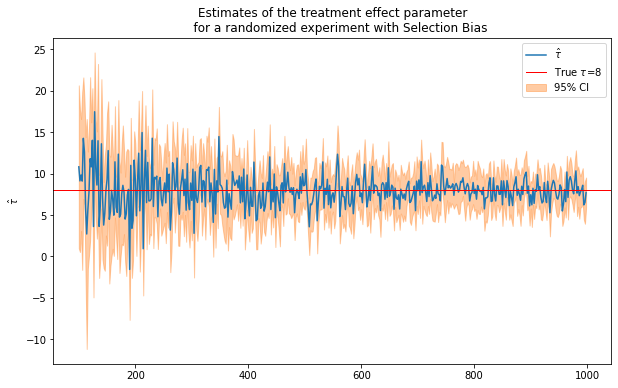

In [321]:
caption = """Estimates of the treatment effect parameter
    for a randomized experiment with Selection Bias"""
fn_plot_with_ci(nvalues4,tauhats4,tau,lb4,ub4,caption)


In [322]:
N = 100
Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf=True)
Yt = Yexp[np.where(T == 1)[0], :]
Yc = Yexp[np.where(T == 0)[0], :]
tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
lb = lb + [tauhat - 1.96 * se_tauhat]
ub = ub + [tauhat + 1.96 * se_tauhat]

tauhat, se_tauhat

(7.68731302771009, 0.25486627607073653)

In [323]:
# check the amount with OLS
const = np.ones([N, 1])

model = sm.OLS(Yexp, np.concatenate([T, const], axis=1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]


(7.687313027710092, 0.2548662760707366)

In [324]:
#R Monte Carlo & bias,RMSE and size
estDict = {}
R = 2000
for N in [100, 1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp, T = fn_generate_data(tau, N, 10, 0, corr, conf)
        Yt = Yexp[np.where(T == 1)[0], :]
        Yc = Yexp[np.where(T == 0)[0], :]
        tauhat, se_tauhat = fn_tauhat_means(Yt, Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat': np.array(tauhats).reshape([len(tauhats), 1]),
        'sehat': np.array(sehats).reshape([len(sehats), 1])
    }

100%|██████████| 2000/2000 [00:08<00:00, 249.95it/s]


In [325]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.005502911099084819, RMSE=0.2270348371580252, size=0.0475
N=1000: bias=-0.0011160820006078697, RMSE=0.07537990996895208, size=0.046
